# Convolutional & Denoising Autoencoders

The insights, Convolutional Neural Networks, suggest we incorporate convolutional layers into the autoencoder to extract information characteristic of the grid-like structure of image data.

Source: https://blog.keras.io/building-autoencoders-in-keras.html

## Imports & Settings

In [1]:
from os.path import join
import pandas as pd

import numpy as np
from numpy.random import choice
from numpy.linalg import norm
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from mpl_toolkits.axes_grid1 import make_axes_locatable

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras import regularizers
from keras.models import Model, model_from_json
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.datasets import fashion_mnist
from keras import backend as K

from sklearn.preprocessing import minmax_scale
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

from scipy.spatial.distance import pdist, cdist

2025-10-25 15:59:58.655436: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%matplotlib inline
plt.style.use('ggplot')
n_classes = 10 # all examples have 10 classes
cmap = sns.color_palette('Paired', n_classes)
pd.options.display.float_format = '{:,.2f}'.format

## Fashion MNIST Data

In [3]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [4]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [5]:
class_dict = {0: 'T-shirt/top',
              1: 'Trouser',
              2: 'Pullover',
              3: 'Dress',
              4: 'Coat',
              5: 'Sandal',
              6: 'Shirt',
              7: 'Sneaker',
              8: 'Bag',
              9: 'Ankle boot'}
classes = list(class_dict.keys())

## Reshape & normalize Fashion MNIST data

In [6]:
image_size = 28

In [7]:
def data_prep_conv(x, size=image_size):
    return x.reshape(-1, size, size, 1).astype('float32')/255

In [8]:
X_train_scaled = data_prep_conv(X_train)
X_test_scaled = data_prep_conv(X_test)

In [9]:
X_train_scaled.shape, X_test_scaled.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

## Combine training steps into function

In [10]:
def train_autoencoder(path, model, x_train=X_train_scaled, x_test=X_test_scaled):
    callbacks = [EarlyStopping(patience=5, restore_best_weights=True),
                 ModelCheckpoint(filepath=path, save_best_only=True, save_weights_only=True)]
    model.fit(x=x_train, y=x_train, epochs=100, validation_split=.1, callbacks=callbacks)
    model.load_weights(path)
    mse = model.evaluate(x=x_test, y=x_test)
    return model, mse

## Convolutional Autoencoder

We define a three-layer encoder that uses 2D convolutions with 32, 16, and 8 filters, respectively, ReLU activations, and 'same' padding to maintain the input size. The resulting encoding size at the third layer is................, higher than for the preceding examples:

### 3-dim input

In [11]:
input_ = Input(shape=(28, 28, 1), name='Input_3D')

### Encoding Layers

In [13]:
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='Encoding_Conv_1')(input_)
x = MaxPooling2D(pool_size=(2, 2), padding='same', name='Encoding_Max_1')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='Encoding_Conv_2')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same', name='Encoding_Max_2')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='Encoding_Conv_3')(x)
encoded_conv = MaxPooling2D(pool_size=(2, 2), padding='same', name='Encoding_Max_3')(x)

We also define a matching decoder that reverses the number of filters and uses 2D upsampling instead of max pooling to reverse the reduction of the filter sizes. The three-layer autoencoder has 12,785 parameters, a little more than 5% of the capacity of the preceding deep autoencoder.

In [14]:
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='Decoding_Conv_1')(encoded_conv)
x = UpSampling2D((2, 2), name='Decoding_Up_1')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='Decoding_Conv_2')(x)
x = UpSampling2D((2, 2), name='Decoding_Up_2')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='Decoding_Conv_3')(x)
x = UpSampling2D((2, 2), name='Decoding_Up_3')(x)
decoded_conv = Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same', name='Decoding_Conv_4')(x)

In [15]:
autoencoder_conv = Model(input_, decoded_conv)
autoencoder_conv.compile(optimizer='adam', loss='mse')

In [16]:
autoencoder_conv.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_3D (InputLayer)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoding_Conv_1 (Conv2D)        │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoding_Max_1 (MaxPooling2D)   │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoding_Conv_2 (Conv2D)        │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoding_Max_2 (MaxPooling2D)   │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoding_Conv_3 (Conv2D)        │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoding_Max_3 (MaxPooling2D)   │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoding_Conv_1 (Conv2D)        │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoding_Up_1 (UpSampling2D)    │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoding_Conv_2 (Conv2D)        │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoding_Up_2 (UpSampling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoding_Conv_3 (Conv2D)        │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoding_Up_3 (UpSampling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoding_Conv_4 (Conv2D)        │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,801 (1.27 MB)

 Trainable params: 332,801 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def train_autoencoder(path, model, x_train, x_test):
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
    callbacks = [EarlyStopping(patience=5, restore_best_weights=True),
                 ModelCheckpoint(filepath=path, save_best_only=True, save_weights_only=True)]
    model.fit(x=x_train, y=x_train, epochs=100, validation_data=(x_test, x_test), callbacks=callbacks)
    model.load_weights(path)
    mse = model.evaluate(x=x_test, y=x_test, verbose=0)
    return model, mse

In [19]:
path = 'models/fashion_mnist.autencoder_conv.32.weights.h5'

In [25]:
autoencoder_conv = build_autoencoder(input_shape=(32, 32, 1))
autoencoder_deep, mse = train_autoencoder(path, 
                                          autoencoder_conv, 
                                          x_train=X_train_resized, 
                                          x_test=X_test_resized)

print(f"Mean Squared Error (MSE) sur les données de test : {mse}")

Epoch 1/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 294s 155ms/step - loss: 0.0162 - val_loss: 0.0042
Epoch 2/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 316s 152ms/step - loss: 0.0039 - val_loss: 0.0031
Epoch 3/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 303s 161ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 4/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 295s 157ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 5/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 327s 175ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 6/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 324s 173ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 7/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 334s 178ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 8/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 347s 185ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 9/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 346s 185ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 10/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 314s 148ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 11/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 327s 174ms/step - loss: 0

Epoch 63/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 261s 139ms/step - loss: 7.2548e-04 - val_loss: 7.6862e-04
Epoch 64/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 251s 134ms/step - loss: 7.2090e-04 - val_loss: 7.1635e-04
Epoch 65/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 249s 133ms/step - loss: 7.1588e-04 - val_loss: 7.1641e-04
Epoch 66/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 250s 133ms/step - loss: 7.1435e-04 - val_loss: 7.6269e-04
Epoch 67/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 250s 133ms/step - loss: 7.0643e-04 - val_loss: 7.0863e-04
Epoch 68/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 274s 146ms/step - loss: 7.1136e-04 - val_loss: 6.9932e-04
Epoch 69/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 31876s 17s/step - loss: 6.9806e-04 - val_loss: 7.3217e-04
Epoch 70/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 312s 162ms/step - loss: 6.9607e-04 - val_loss: 7.0019e-04
Epoch 71/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 297s 159ms/step - loss: 6.8541e-04 - val_loss: 7.1190e-04
Epoch 72/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 355s 189ms/step - loss: 6.8870e-04 - v

Training stops after 75 epochs and results in a further 9% reduction of the test RMSE, due to a combination of the ability of convolutional filters to learn more efficiently from image data and the larger encoding size.

In [26]:
f'MSE: {mse:.4f} | RMSE {mse**.5:.4f}'

'MSE: 0.0006 | RMSE 0.0251'

In [30]:
autoencoder_conv.load_weights(path)

In [32]:
X_test_expanded = tf.expand_dims(X_test_scaled, axis=-1)
X_test_resized = tf.image.resize(X_test_expanded, (32, 32))
reconstructed_images = autoencoder_deep.predict(X_test_resized)
print("Forme des images reconstruites:", reconstructed_images.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step
Forme des images reconstruites: (10000, 32, 32, 1)


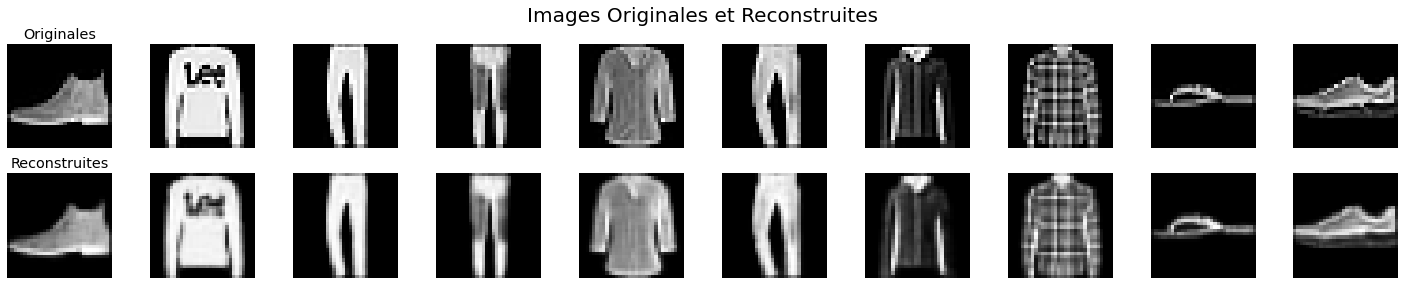

In [38]:
fig, axes = plt.subplots(ncols=n_classes, nrows=2, figsize=(20, 4))

for i in range(n_classes):
    
    # Affichage des images originales (28x28)
    axes[0, i].imshow(X_test_scaled[i].reshape(image_size_original, image_size_original), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Originales')

    # Affichage des images reconstruites (32x32)
    axes[1, i].imshow(reconstructed_images[i].reshape(image_size_reconstructed, image_size_reconstructed) , cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Reconstruites')

fig.suptitle('Images Originales et Reconstruites', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.85)
fig.savefig('figures/autoencoder_reconstruction.png', dpi=300)
plt.show()

## Denoising Autoencoder

The application of an autoencoder to a denoising task only affects the training stage. In this example, we add noise to the Fashion MNIST data from a standard normal distribution while maintaining the pixel values in the range of [0, 1], as follows:

In [39]:
def add_noise(x, noise_factor=.3):
    return np.clip(x  + noise_factor * np.random.normal(size=x.shape), 0, 1)

In [40]:
X_train_noisy = add_noise(X_train_scaled)
X_test_noisy = add_noise(X_test_scaled)

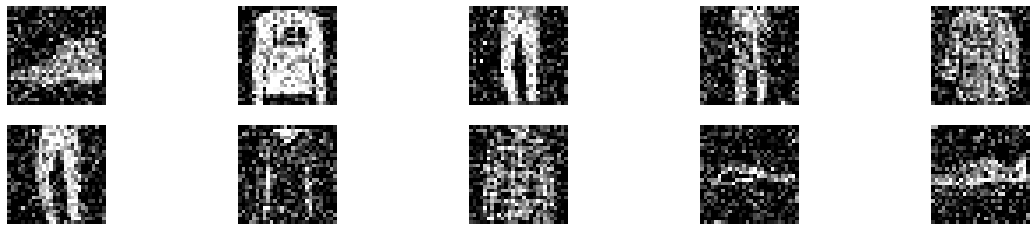

In [41]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 4))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(X_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

In [47]:
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='Encoding_Conv_1')(input_)
x = MaxPooling2D(pool_size=(2, 2), padding='same', name='Encoding_Max_1')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='Encoding_Conv_2')(x)
encoded_conv = MaxPooling2D(pool_size=(2, 2), padding='same', name='Encoding_Max_3')(x)

In [48]:
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='Decoding_Conv_1')(encoded_conv)
x = UpSampling2D(size=(2, 2), name='Decoding_Upsample_1')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='Decoding_Conv_2')(x)
x = UpSampling2D(size=(2, 2), name='Decoding_Upsample_2')(x)
decoded_conv = Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same', name='Decoding_Conv_4')(x)

In [49]:
autoencoder_denoise = Model(input_, decoded_conv)
autoencoder_denoise.compile(optimizer='adam', loss='mse')

In [52]:
path = 'models/fashion_mnist.autencoder_denoise.32.weights.h5'

In [55]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath=path, save_best_only=True, save_weights_only=True)
]

We then proceed to train the convolutional autoencoder on noisy input with the objective to learn how to generate the uncorrupted originals:

In [56]:
autoencoder_denoise.fit(x=X_train_noisy,
                        y=X_train_scaled,
                        epochs=40,
                        batch_size=128,
                        shuffle=True,
                        validation_split=.1,
                        callbacks=callbacks)

Epoch 1/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 177s 408ms/step - loss: 0.0399 - val_loss: 0.0146
Epoch 2/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 159s 377ms/step - loss: 0.0141 - val_loss: 0.0126
Epoch 3/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 130s 309ms/step - loss: 0.0123 - val_loss: 0.0114
Epoch 4/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 143s 338ms/step - loss: 0.0112 - val_loss: 0.0105
Epoch 5/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 144s 342ms/step - loss: 0.0104 - val_loss: 0.0100
Epoch 6/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 147s 349ms/step - loss: 0.0099 - val_loss: 0.0097
Epoch 7/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 130s 308ms/step - loss: 0.0097 - val_loss: 0.0095
Epoch 8/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 156s 369ms/step - loss: 0.0094 - val_loss: 0.0093
Epoch 9/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 123s 290ms/step - loss: 0.0092 - val_loss: 0.0091
Epoch 10/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 187s 443ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 11/40
422/422 ━━━━━━━━━━━━━━━━━━━━ 228s 541ms/step - loss: 0.0090 - val_loss: 0.0089
Epoch 12

In [31]:
autoencoder_denoise.load_weights(path)

In [32]:
mse = autoencoder_denoise.evaluate(x=X_test_noisy, y=X_test_scaled)
f'MSE: {mse:.4f} | RMSE {mse**.5:.4f}'

10000/10000 [==============================] - 1s 106us/step


'MSE: 0.0086 | RMSE 0.0925'

## Visualize Reconstructed Images

The following figure shows, from top to bottom, the original images as well as the noisy and denoised versions. It illustrates that the autoencoder is successful in producing compressed encodings from the noisy images that are quite similar to those produced from the original images:

In [33]:
reconstructed_images = autoencoder_denoise.predict(X_test_noisy)
reconstructed_images.shape

(10000, 28, 28, 1)

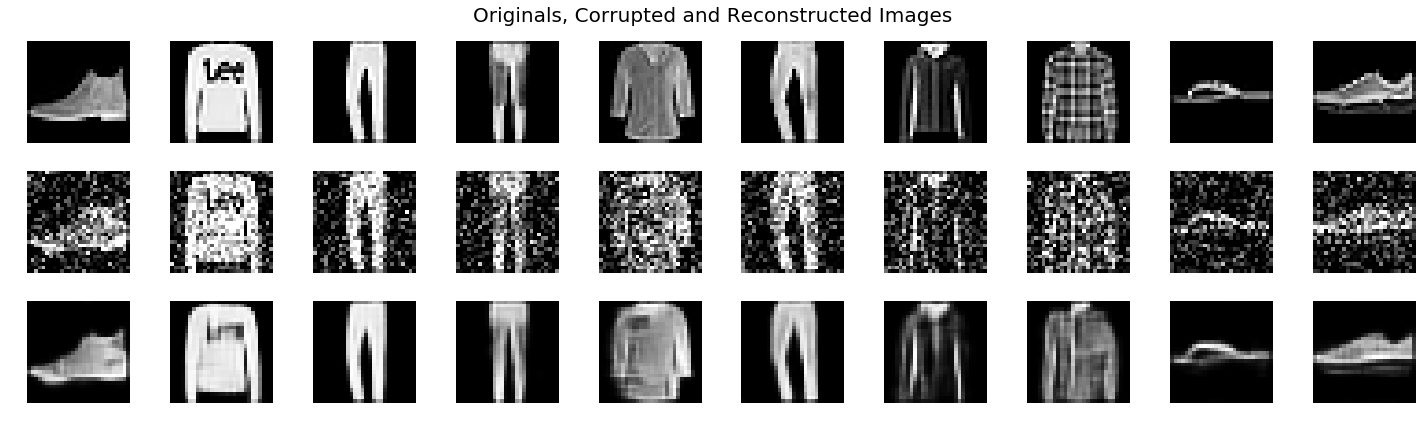

In [34]:
fig, axes = plt.subplots(ncols=n_classes, nrows=3, figsize=(20, 6))
for i in range(n_classes):
    axes[0, i].imshow(X_test[i].reshape(image_size, image_size), cmap='gray')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(X_test_noisy[i].reshape(image_size, image_size), cmap='gray')
    axes[1, i].axis('off')

    axes[2, i].imshow(reconstructed_images[i].reshape(image_size, image_size) , cmap='gray')
    axes[2, i].axis('off')
fig.suptitle('Originals, Corrupted and Reconstructed Images', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig('figures/autoencoder_denoising', dpi=300)